# Kaggle Housing Regression Project

## Overview
This is a project based on the Kaggle Housing Regression Competition (https://www.kaggle.com/c/house-prices-advanced-regression-techniques/).

This notebook provides:
1. Overview of the EDA process used for feature engineering
2. Model training and prediction
3. Conclusions and key takeaways

Apart from this notebook, this project is having following Python Code. 

In order to run the project from scratch, one would need to run the following files in order:

`src/download_dataset.py`

To install the Kaggle package and download the Housing Regression Competition data into the data/raw folder

` src/unzip_dataset.py`

To unzip the downloaded dataset in the data/raw folder

`src/create_features.py`

To generate cleaned features / engineered features and save them in the modeling folder

Finally, run the 20200412_project_4_housing_kzp.ipynb file (this notebook) to read in the cleaned/engineered features and create models/outputs. Note that the outputs will be saved in the outputs folder.

Use the environment.yml file to create a Conda environment with all the packages used by this project. Alternatively, you can just files below and install packages one-by-one as needed.

The entire project (with all mentioned files/code) can be found at https://github.com/zijianwu/w207-project4-kzp

In [1]:
import warnings
warnings.filterwarnings("ignore")

# Import packages and define functions

In [2]:
import multiprocessing as mp
import os

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set_context('notebook')
sns.set_style('white')
%matplotlib inline

from utils import *
from ipywidgets import interact, fixed
from sklearn.preprocessing import PowerTransformer, StandardScaler
import multiprocessing
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import RidgeCV
from sklearn.svm import SVR, LinearSVR
import shap
from copy import deepcopy
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesRegressor
import xgboost as xgb
from mlxtend.regressor import StackingRegressor
from sklearn.model_selection import KFold
from functools import partial
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import lightgbm as lgbm
shap.initjs()

# EDA and Feature Engineering

In [3]:
train = pd.read_csv('../data/raw/train.csv', index_col=0)
test = pd.read_csv('../data/raw/test.csv', index_col=0)

In [4]:
nominal = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LandContour', 'LotConfig',
           'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
           'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
           'Foundation', 'Heating', 'CentralAir', 'GarageType', 'MiscFeature',
           'SaleType', 'SaleCondition']
ordinal = ['LotShape', 'Utilities', 'LandSlope', 'OverallQual', 'OverallCond',
           'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
           'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'Electrical', 'KitchenQual',
           'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond',
           'PavedDrive', 'PoolQC', 'Fence']
quantitative = ['YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath',
                'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
                'Fireplaces', 'GarageYrBlt', 'GarageCars', 'MoSold', 'YrSold',
                'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',  'BsmtFinSF2',
                'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
                'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
                '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']
y_var = 'SalePrice'

## Dependent Variable

As the dependent variable is highly right skewed, we log-transform the dependent variable. This also allows us to take the root mean squared error of the log-transformed variables in our model selection as the house price Kaggle scores SalesPrice based on the root mean squared log error (so that errors are proportional to the price of the house).

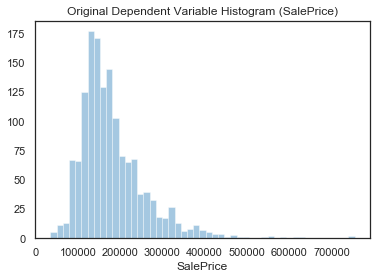

In [5]:
sns.distplot(train[y_var], kde=False)
plt.title('Original Dependent Variable Histogram (SalePrice)');

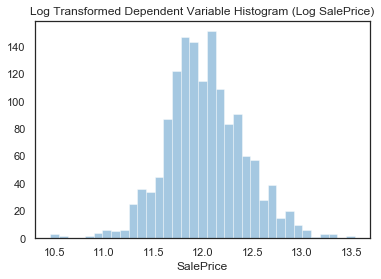

In [6]:
train[y_var] = np.log(train[y_var])
sns.distplot(train[y_var], kde=False)
plt.title('Log Transformed Dependent Variable Histogram (Log SalePrice)');

## Nominal Variables

For nominal variables, use interactive iPyWidgets to look at:
* How the dependent variable varies with each feature value
* How sparse each feature value is
* How many NaNs are in each feature

Using the plots, we can determine for which features we need to fill NaNs and which feature values we can combine with other feature values (due to sparsity or due to similar average dependent variable).

In [7]:
interact(plot_categorical_univariate_feature, 
         feature=nominal,
         y_var=fixed(y_var),
         df_train=fixed(train),
         df_test=fixed(test));

interactive(children=(Dropdown(description='feature', options=('MSSubClass', 'MSZoning', 'Street', 'Alley', 'L…

While all of the transformations that we've created are in the `create_features.py` file, we've highlighted some of the data we've found and some of the transformations below.

For example, we have done the following transformations in addition to creating dummy variables where appropriate so that the final dataframe has only quantitative variables:
 * **Foundation**: combined CBlock and Stone as well as Wood and PConc as they have similar dependent variable effects, and one of the feature variables in each pair are very sparse
 * **MSSubClass**: combined a number of sparse features together with features that are less sparse but have similar average dependent variables
 * **Heating**: combined sparse features together into "Other"
 * **CentralAir**: created binary variable from the categorical strings

The training set has 0 nulls.
The testing set has 0 nulls.


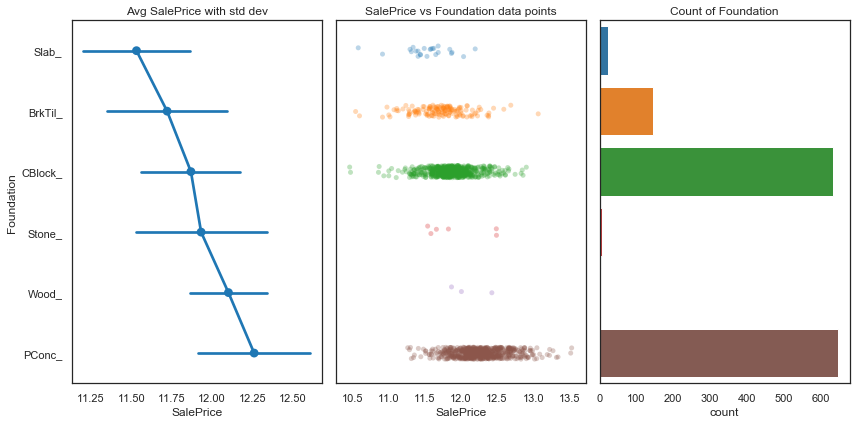

In [8]:
plot_categorical_univariate_feature(feature='Foundation', 
                                    y_var=y_var, 
                                    df_train=train, 
                                    df_test=test)

def no_uncommon_Foundation(df):
    mapping_dict = {
        "PConc": "PConc",
        "CBlock": "CBlock",
        "BrkTil": "BrkTil",
        "Slab": "Slab",
        "Stone": "CBlock",
        'Wood': 'PConc'}
    result = df['Foundation'].map(mapping_dict)
    result.name = 'no_uncommon_Foundation'
    result = pd.get_dummies(result, prefix=result.name, drop_first=True)
    return result

The training set has 0 nulls.
The testing set has 0 nulls.


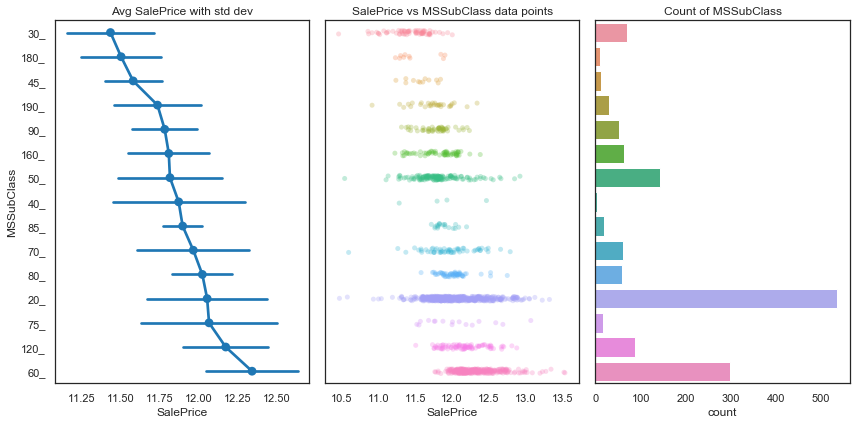

In [9]:
plot_categorical_univariate_feature(feature='MSSubClass', 
                                    y_var=y_var, 
                                    df_train=train, 
                                    df_test=test)

def no_uncommon_MSSubClass(df):
    mapping_dict = {
        20: "20, 75",
        30: "30, 180, 45",
        40: "50, 40",
        45: "30, 180, 45",
        50: "50, 40",
        60: "60",
        70: "70",
        75: "20, 75",
        80: "80",
        85: "85",
        90: "90",
        120: "120",
        150: "150",
        160: "160",
        180: "30, 180, 45",
        190: "190"}
    result = df['MSSubClass'].map(mapping_dict)
    result.name = 'no_uncommon_MSSubClass'
    result = pd.get_dummies(result, prefix=result.name, drop_first=True)
    return result

The training set has 0 nulls.
The testing set has 0 nulls.


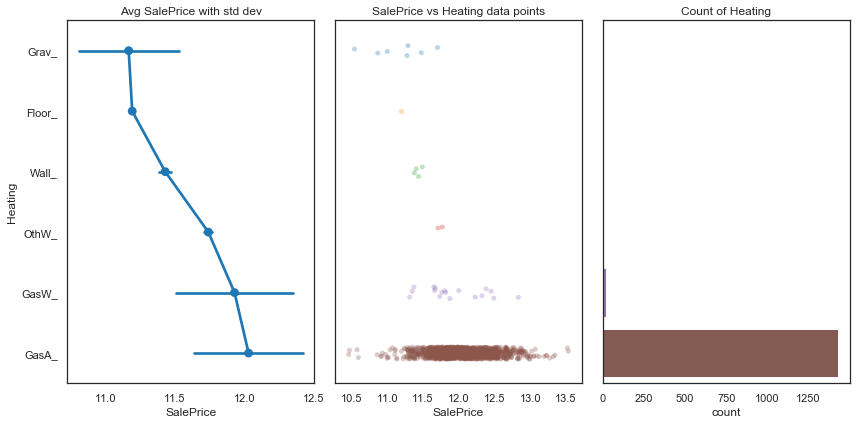

In [10]:
plot_categorical_univariate_feature(feature='Heating', 
                                    y_var=y_var, 
                                    df_train=train, 
                                    df_test=test)

def no_uncommon_Heating(df):
    mapping_dict = {
        "GasA": "GasA",
        "GasW": "Other",
        "Wall": "Other",
        "Slab": "Other",
        "OthW": "Other",
        'Floor': 'Other'}
    result = df['Heating'].map(mapping_dict)
    result.name = 'no_uncommon_Heating'
    result = pd.get_dummies(result, prefix=result.name, drop_first=True)
    return result

The training set has 0 nulls.
The testing set has 0 nulls.


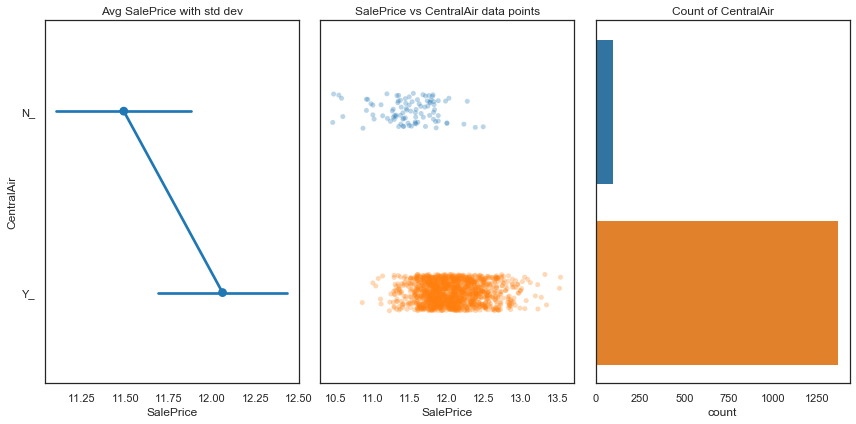

In [11]:
plot_categorical_univariate_feature(feature='CentralAir', 
                                    y_var=y_var, 
                                    df_train=train, 
                                    df_test=test)

def binary_CentralAir(df):
    mapping_dict = {
        'Y': 1,
        'N': 0}
    result = df['CentralAir'].map(mapping_dict)
    result.name = 'binary_CentralAir'
    return result

## Ordinal variables

For ordinal variables, use interactive iPyWidgets to look at:
* How the dependent variable varies with each feature value
* How sparse each feature value is
* How many NaNs are in each feature

Using the plots, we can determine for which features we need to fill NaNs, which feature values we can combine with other feature values (due to sparsity or due to similar average dependent variable), and which features should be ordinally encoded (into integers) higher than other features.

In [12]:
interact(plot_categorical_univariate_feature, 
         feature=ordinal,
         y_var=fixed(y_var),
         df_train=fixed(train),
         df_test=fixed(test));

interactive(children=(Dropdown(description='feature', options=('LotShape', 'Utilities', 'LandSlope', 'OverallQ…

While all of the transformations that we've created are in the `create_features.py` file, we've highlighted some of the data we've found and some of the transformations below.

For example, we have done the following transformations to encode the ordinal variables using numbers:
 * **ExterQual**: mapped features to numbers based on definitions as the feature set is very clean with a strong trend with the dependent variable
 * **Utilities**: mapped NaNs to AllPub (all utilities available) due to feature prevalence
 * **OverallCond**: combined a lower rating variables together as they have low count and have the same effect

The training set has 0 nulls.
The testing set has 0 nulls.


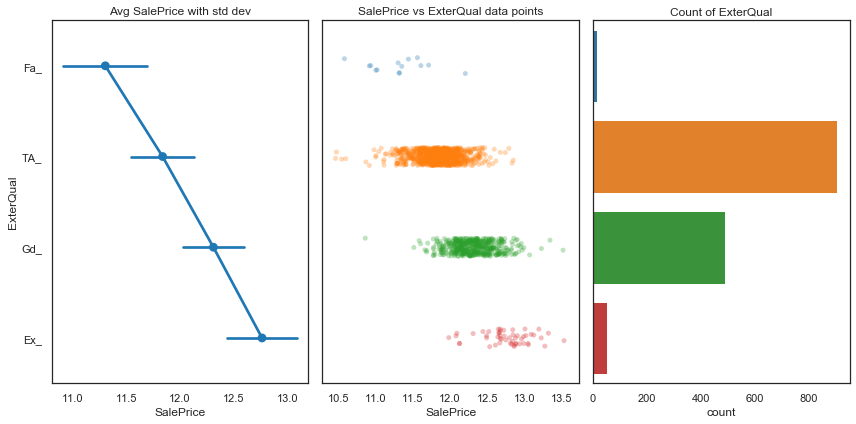

In [13]:
plot_categorical_univariate_feature(feature='ExterQual', 
                                    y_var=y_var, 
                                    df_train=train, 
                                    df_test=test)

def ordinal_ExterQual(df):
    mapping_dict = {
        "Ex": 4,
        "Gd": 3,
        "TA": 2,
        "Fa": 1,
        "Po": 0}
    result = df['ExterQual'].map(mapping_dict)
    result.name = 'ordinal_ExterQual'
    return result

The training set has 0 nulls.
The testing set has 2 nulls.


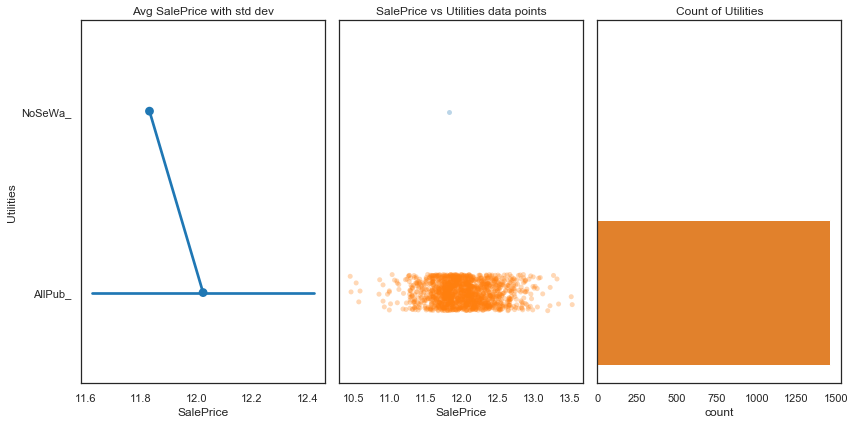

In [14]:
plot_categorical_univariate_feature(feature='Utilities', 
                                    y_var=y_var, 
                                    df_train=train, 
                                    df_test=test)

def ordinal_Utilites(df):
    mapping_dict = {
        "AllPub": 3,
        "NoSewr": 2,
        "NoSeWa": 1,
        "ELO": 0,
        np.nan: 3}
    result = df['Utilities'].map(mapping_dict)
    result.name = 'ordinal_Utilites'
    return result

The training set has 0 nulls.
The testing set has 0 nulls.


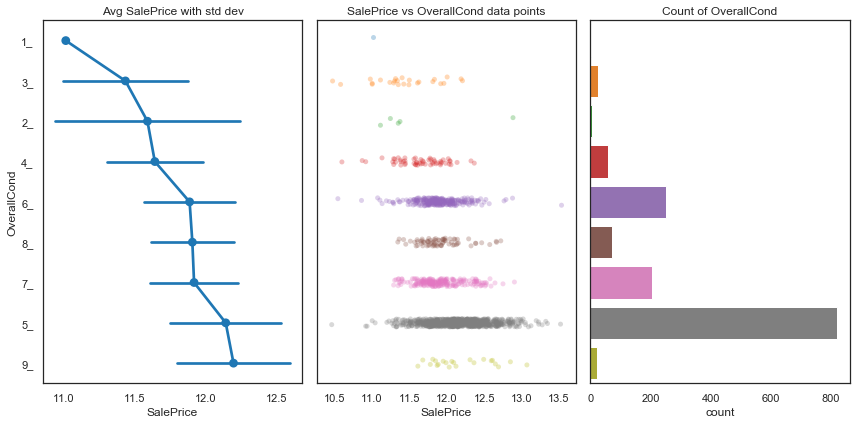

In [15]:
plot_categorical_univariate_feature(feature='OverallCond', 
                                    y_var=y_var, 
                                    df_train=train, 
                                    df_test=test)

def ordinal_OverallCond(df):
    mapping_dict = {
        1: 0, 
        2: 0, 
        3: 0, 
        4: 1, 
        5: 2, 
        6: 3, 
        7: 4, 
        8: 5, 
        9: 6,
        10: 7}
    result = df['OverallCond'].map(mapping_dict)
    result.name = 'ordinal_OverallCond'
    return result

## Quantitative Variables

For quantitative variables, use interactive iPyWidgets to look at how the depedent variable changes with each feature as it undergoes the following transformations:
 * Untransformed
 * Log
 * Sqrt
 * Square
 * PowerTransform
 * StandardScale

Using the plots, we can determine for which features we need to fill NaNs and how we can transform the dependent variables so that they are more normally distributed or cleaner (e.g., binarized).

In [16]:
interact(plot_quantitative_univariate_feature, 
         feature=quantitative,
         y_var=fixed(y_var),
         df_train=fixed(train),
         df_test=fixed(test));

interactive(children=(Dropdown(description='feature', options=('YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'B…

While all of the transformations that we've created are in the `create_features.py` file, we've highlighted some of the data we've found and some of the transformations below.

For example, we have done the following transformations to encode the quantitative variables:
 * **1stFlrSF**: power transformed for more normal distribution
 * **LowQualFinSF**: made quantitative feature binary due to low counts for certain features
 * **PoolArea**: made quantitative feature binary due to low counts for certain features

The training set has 0 nulls.
The testing set has 0 nulls.


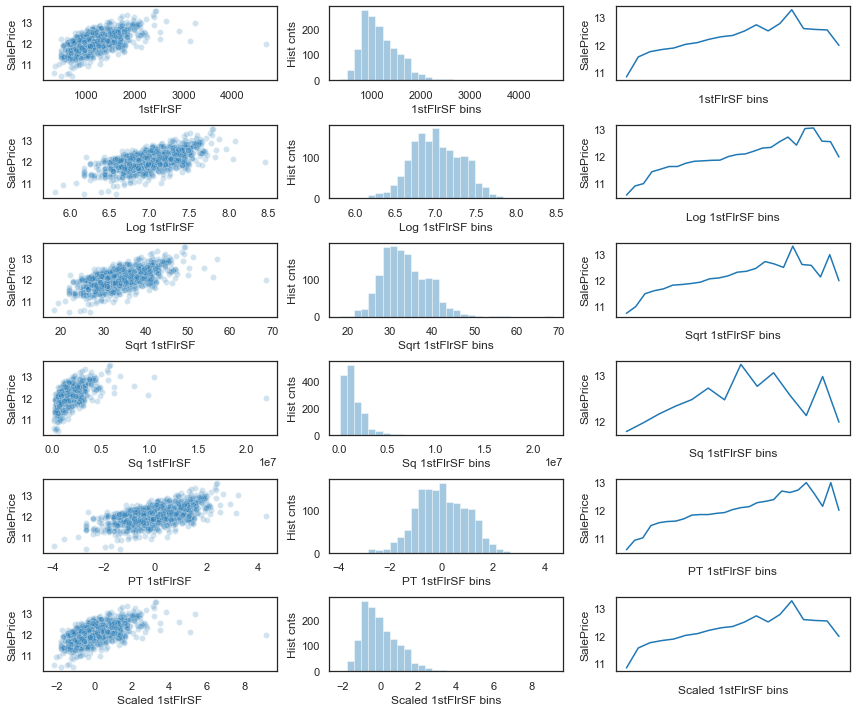

In [17]:
plot_quantitative_univariate_feature(feature='1stFlrSF',
                                     y_var=y_var,
                                     df_train=train,
                                     df_test=test)


def use_power_transformed_1stFlrSF(train, test):
    pt = PowerTransformer()
    train_result = pd.DataFrame(pt.fit_transform(train[['1stFlrSF']]), columns=['power_transformed_1stFlrSF'],
                                index=train.index)
    train_result.to_parquet(
        f"{path}/../data/modeling/{'power_transformed_1stFlrSF'}_train.parquet")
    test_result = pd.DataFrame(pt.transform(test[['1stFlrSF']]), columns=['power_transformed_1stFlrSF'],
                               index=test.index)
    test_result.to_parquet(
        f"{path}/../data/modeling/{'power_transformed_1stFlrSF'}_test.parquet")
    return train_result, test_result

The training set has 0 nulls.
The testing set has 0 nulls.


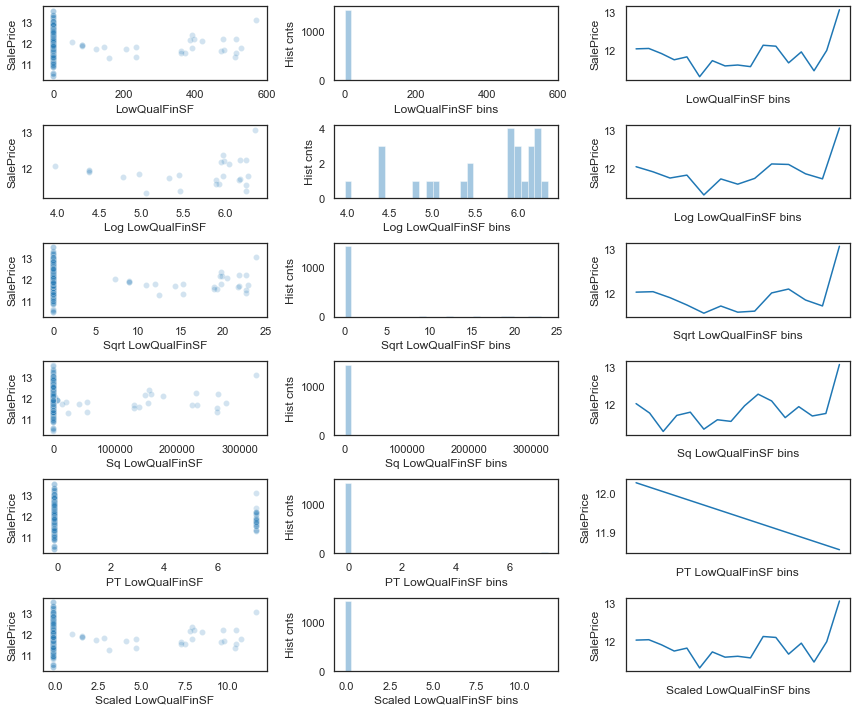

In [18]:
plot_quantitative_univariate_feature(feature='LowQualFinSF',
                                     y_var=y_var,
                                     df_train=train,
                                     df_test=test)

def binary_LowQualFinSF(df):
    result = df['LowQualFinSF'] != 0
    result.name = 'binary_LowQualFinSF'
    return result

The training set has 0 nulls.
The testing set has 0 nulls.


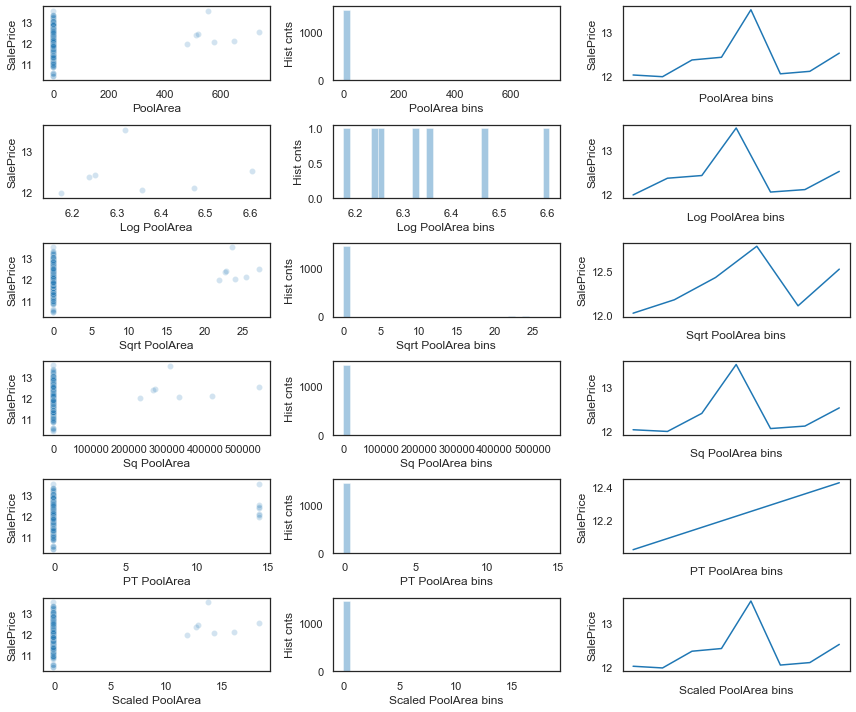

In [19]:
plot_quantitative_univariate_feature(feature='PoolArea', 
                                    y_var=y_var, 
                                    df_train=train, 
                                    df_test=test)

def binary_PoolArea(df):
    result = df['PoolArea'] != 0
    result.name = 'binary_PoolArea'
    return result

We also create a heatmap of the feature correlations below. While we notice that some features are somewhat highly correlated, there are no features that are correlated enough to warrant removing.

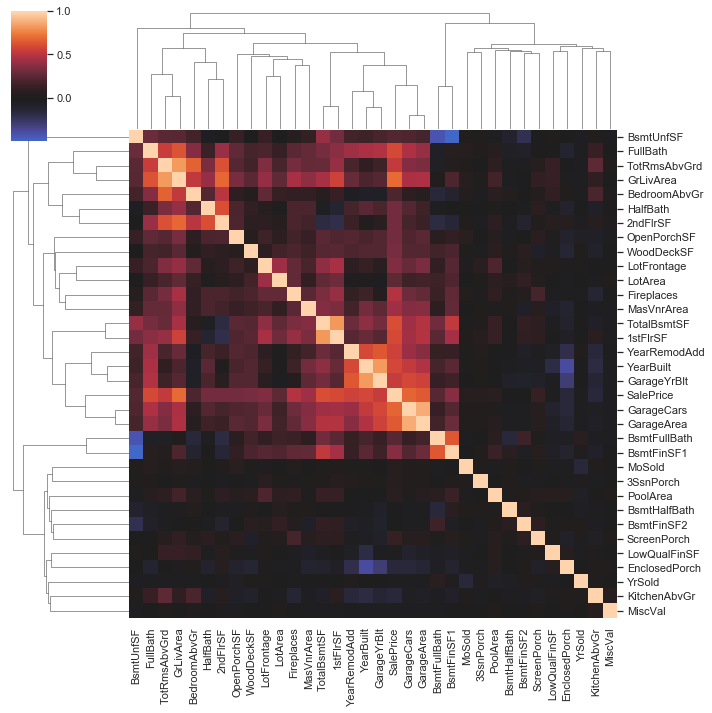

In [20]:
sns.clustermap(train[[y_var]+quantitative].corr(), center=0)

# Modeling

We start by figuring out how many processors our machine has (to speed up later model traning steps).

If we want to re-determine the best hyperparameters for our models, we can set `retrain=True`.

Lastly, we read in all of the cleaned/engineered fetures we had creating used the `src/create_features.py`.

In [21]:
n_processes = multiprocessing.cpu_count()
retrain=False

X_train, y_train, X_test = read_features('../data/modeling/')

We notice below that there are still some NaNs in our dataset, so we'll have to be sure to fill those in before modeling (or use a modeling technique that accepts NaNs for who they are, like XGBoost).

In [22]:
X_train.isna().sum().sort_values(ascending=False).head(10)

unchanged_LotFrontage               259
unchanged_GarageYrBlt                81
unchanged_MasVnrArea                  8
no_uncommon_Neighborhood_Somerst      0
no_uncommon_GarageType_Basment        0
no_uncommon_GarageType_Attchd         0
ordinal_GarageFinish                  0
unchanged_BsmtFinSF2                  0
no_uncommon_Neighborhood_Veenker      0
no_uncommon_Neighborhood_Timber       0
dtype: int64

## Baseline

We start by creating a baseline linear regression model with L2 regularization. 

Note that we do not standardize our features prior to the modeling. This is because when we create features using the `src/create_features.py`, we create both a cleaned/engineered version of the features (which is typically standardized/normalized) while keeping in the original feature (which is typically not standardized). 

We could have chosen to perform feature selection or dimensionality reduction prior to modeling to remove the duplicate features; however, for a convenient and fast baseline, we decided to simply use regularized regression without standardization, so that the "original" features are ignored due to regularization while the more important engineered features (already normalized/standardized) are given more weight by the model.

### Score

For a convenient baseline, we've decided to simply fill in the NaNs with the medians for the respective columns. Please see next steps / conclusion for thoughts on other ways to fill in NaNs (e.g., MICE, mode, zeroes).

In [23]:
X_train, y_train, X_test = read_features('../data/modeling/')
X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_train.median())

In [24]:
# ridge = make_pipeline(StandardScaler(),
#                       RidgeCV(cv=5, scoring='neg_root_mean_squared_error'))
ridge = RidgeCV(cv=5, scoring='neg_root_mean_squared_error')
result = cross_val_score(ridge, X_train, y_train,
                         scoring='neg_root_mean_squared_error',
                         cv=5,
                         n_jobs=-1,
                         verbose=0)
print("RMSE:", np.mean([(ele*-1) for ele in result]))

RMSE: 0.1308508044551639


In [25]:
ridge.fit(X_train, y_train)
ridge_result = predict_transform_from_test_set(ridge, X_test)
ridge_result.to_csv(f"../outputs/ridge_result.csv", index=False)

Score on Kaggle: 0.12562

### Error Analysis

We first view the errors in our trained model. Note that each of the predictions shown below are created using leave-one-out cross validation on the training set. As the training dataset is rather small, we decided to use cross validation rather than creating a separate validation set.

We immediately notice that there are two strong outliers indicated by index number 1299 and 524.

In [26]:
plot_residual_prediction_from_train(ridge, X_train, y_train, cv=len(X_train), n_jobs=-1)

We take a look at the SHAP force plots in order to determine whether there are particular common features that are causing the highly erroneous predictions. We see that for both, GrLivArea, 1stFlrSF, and TotalBsmtSF seem to have a big effect.

In [27]:
get_force_plot_for_sample_in_train_loo(ridge, X_train, y_train, index=1299)

In [28]:
get_force_plot_for_sample_in_train_loo(ridge, X_train, y_train, index=524)

From the plot below, we see that there are a few strong outlier for GrLivArea with values over 4000. It could be that these outliers are reducing the generalizability of our model. 

In [29]:
px.scatter(x=train.loc[:, 'GrLivArea'], y=y_train, hover_name=y_train.index,
           labels={'y': 'SalePrice', 'x': 'GrLivArea'},
           title='GrLivArea vs Sale Price', opacity=0.8)

We will try removing these four outliers and retesting the baseline.

## Baseline 2 (removed GrLivArea outliers)

### Score

For our second baseline, we remove the outliers from GrLivArea

In [30]:
indices_to_drop = train[train['GrLivArea'] > 4000].index

X_train, y_train, X_test = read_features('../data/modeling/')
X_train = X_train.drop(indices_to_drop, axis=0)
y_train = y_train.drop(indices_to_drop, axis=0)
X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_train.median())

In [31]:
ridge2 = RidgeCV(cv=5, scoring='neg_root_mean_squared_error')

result = cross_val_score(ridge2, X_train, y_train,
                         scoring='neg_root_mean_squared_error',
                         cv=5,
                         n_jobs=-1,
                         verbose=0)
print("RMSE:", np.mean([(ele*-1) for ele in result]))

RMSE: 0.11376313701137405


In [32]:
ridge2.fit(X_train, y_train)
ridge_result2 = predict_transform_from_test_set(ridge2, X_test)
ridge_result2.to_csv(f"../outputs/ridge_result2.csv", index=False)

Score on Kaggle: 0.12021

Since we see that removing these outliers has increased both our Kaggle score significantly, we will continue to keep the outliers out for future models.

### Error Analysis

Taking a look at the prediction vs residual plots, we see that index ID 31 has the largest error. We will further analyze what which features are causing the biggest error.

In [33]:
plot_residual_prediction_from_train(ridge2, X_train, y_train, cv=5, n_jobs=-1)

Using the SHAP model interpretability package, we can see below which features have the biggest impact on our SalePrice dependent variable. One thing we do see is that because we are including both the original as well as transformed variables (e.g., GrLivArea), both features are making their way into the most important features chart. As next steps, we should perform some feature selection or extraction (e.g., PCA) to reduce the number of redundant/correlated features.

We should also see if other models that we try (e.g., non-linear) have similar important features or if other features stand out.

Note that the feature importances below (Shapley values) indicate how much each feature pushes the final output (log of SalePrice). This is different from feature importances based on a measure such as the size of the feature coefficients in a standard linear regression. This is because even if a feature coefficient is very large, the feature itself may not vary much - would this feature be "important" in that case or not? On the flip side, if a feature coefficient is very small but the feature itself varies a lot, would this feature be "important"? The feature importances below are more akin to the feature coefficient * feature standard deviation; the features are only indicated as important if they actually push the dependent variable one way or the other.

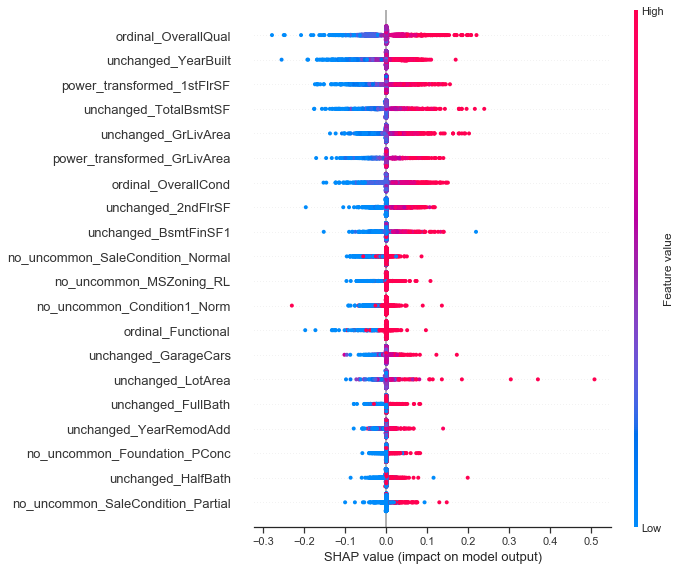

None

In [34]:
expected_value, shap_values = get_feature_importances_for_training(ridge, X_train, y_train, cv=5, tree_shap=False, cv_prediction=True)

Because we noticed above that data point number 31 is very poorly predicted, we compare that data point to a few others in order to determine which features are causing data point 31 to be so poorly predicted. We see that it seems that `ordinal_OverallQual`, `unchanged_YearBuilt`, `no_uncommon_LotConfig_CulDSac`, and `binary_CentralAir` seem to have large effects pushing the log SalePrice up.

As a follow up step for further analysis, we could take a closer look at these features to determine if we might be able to fill NaNs or change features so that they are more informative.

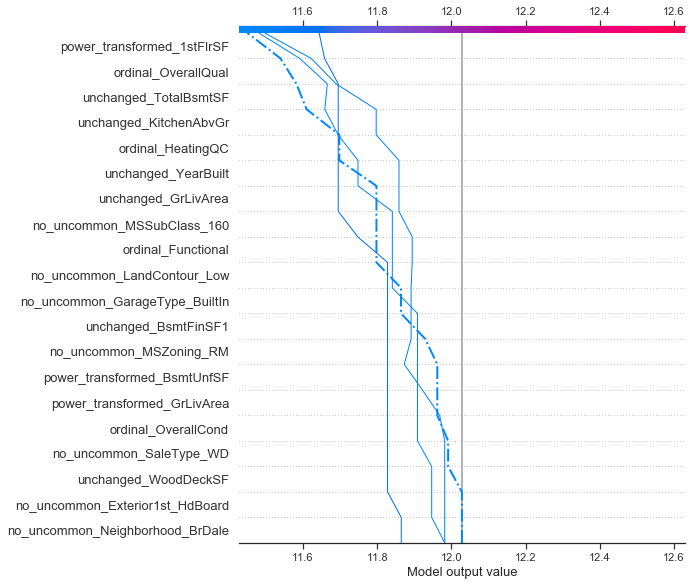

In [35]:
index_names = [31, 838, 76, 433]
idx_nums = [X_train.index.get_loc(ele) for ele in index_names]
shap.decision_plot(expected_value, shap_values[idx_nums,:], X_train.iloc[idx_nums,:], highlight=0)

## SVR

### Score

This algorithm is an application of Support Vector Machines to a linear regression context.  At a Kaggle score of 0.14975, this is one of the least accurate models that we've run on the housing data - although SVR lets us define acceptable error in our model, the specified search space did not yield a model comparable to other algorithms.

In [36]:
indices_to_drop = train[train['GrLivArea'] > 4000].index

X_train, y_train, X_test = read_features('../data/modeling/')
X_train = X_train.drop(indices_to_drop, axis=0)
y_train = y_train.drop(indices_to_drop, axis=0)
X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_train.median())

In [37]:
if retrain:
    estimator = make_pipeline(StandardScaler(),
                              PCA(),
                              SVR())
    # estimator = SVR()
    svr_space = {
                 'pca__n_components': np.linspace(3, int(X_train.shape[1] * 0.6), 10).astype(int),
                 'svr__kernel': ['rbf', 'sigmoid'],
                 'svr__C': np.logspace(0, 2, 10),
                 'svr__epsilon': np.logspace(-5, 0, 10)
                 }

    grid_search = GridSearchCV(
        estimator=estimator,
        param_grid=svr_space,
        scoring='neg_root_mean_squared_error',
        n_jobs=n_processes,
        cv=5,
        verbose=1,
    )

    grid_search.fit(X_train, y_train)
    print(grid_search.best_params_)

In [38]:
if retrain:
    svr = grid_search.best_estimator_
else:
    svr = make_pipeline(StandardScaler(),
                        PCA(n_components=14),
                        SVR(C=1.0, epsilon=0.07742636826811278, kernel='rbf'))
result = cross_val_score(svr, X_train, y_train,
                         scoring='neg_root_mean_squared_error',
                         cv=5,
                         n_jobs=-1,
                         verbose=0)
print("RMSE:", np.mean([(ele*-1) for ele in result]))

RMSE: 0.1421560514214219


In [39]:
svr.fit(X_train, y_train)
svr_result = predict_transform_from_test_set(svr, X_test)
svr_result.to_csv(f"../outputs/svr.csv", index=False)

Kaggle score: 0.14975

### Error Analysis

Using a SVM based regressor with a RBF kernel, we still see below that data point continues to be the least accurate out of all the models produced.  On the low end, we can see Index 31 has a relatively large negative residual, with a value of -0.965, indicating that this model has significantly underestimated its value.  Index 534 is also quite close to 31 in residual value with a vale of -0.957, while 706 is another key overpredicted case at -0.92.  On the high end, Index 186 has by far the largest positive residual, with a value of +0.828.

In [40]:
plot_residual_prediction_from_train(svr, X_train, y_train, cv=5, n_jobs=-1)

## Linear SVR

### Score

This algoritm is similar to SVR, with the exception that it uses liblinear rather than libsvm as part of its kernel parameter.  Practically speaking, this gives linear SVR more flexibility with the penalities and loss function, which is reflected in the results relative to the SVR model.  Still, at a Kaggle scroe of 0.143, it is still inferior to other, non-SVM based models used in this analysis.

In [41]:
indices_to_drop = train[train['GrLivArea'] > 4000].index

X_train, y_train, X_test = read_features('../data/modeling/')
X_train = X_train.drop(indices_to_drop, axis=0)
y_train = y_train.drop(indices_to_drop, axis=0)
X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_train.median())

In [42]:
if retrain:
    estimator = make_pipeline(StandardScaler(),
                              PCA(),
                              LinearSVR())
    # estimator = LinearSVR()
    linearsvr_space = {
                 'pca__n_components': np.linspace(3, int(X_train.shape[1] * 0.6), 10).astype(int),
                 'linearsvr__C': np.logspace(0, 2, 10),
                 'linearsvr__epsilon': np.logspace(-5, 0, 10)
                 }

    grid_search = GridSearchCV(
        estimator=estimator,
        param_grid=linearsvr_space,
        scoring='neg_root_mean_squared_error',
        n_jobs=n_processes,
        cv=5,
        verbose=1,
    )

    grid_search.fit(X_train, y_train)
    print(grid_search.best_params_)

In [43]:
if retrain:
    linearsvr = grid_search.best_estimator_
else:
    linearsvr = make_pipeline(StandardScaler(),
                              PCA(n_components=105),
                              LinearSVR(C=1.0, epsilon=0.07742636826811278))
result = cross_val_score(linearsvr, X_train, y_train,
                         scoring='neg_root_mean_squared_error',
                         cv=5,
                         n_jobs=-1,
                         verbose=0)
print("RMSE:", np.mean([(ele*-1) for ele in result]))

RMSE: 0.1292988181478905


In [44]:
linearsvr.fit(X_train, y_train)
linearsvr_result = predict_transform_from_test_set(linearsvr, X_test)
linearsvr_result.to_csv(f"../outputs/linearsvr.csv", index=False)

Kaggle score: 0.14298

### Error Analysis

Index 31 continues to be heavily overestimated, with a residual value of-0.99.  In this case, though, the next largest negative residual outliers are 464 (-0.742) and 496 (-0.697), which are different from the initial SVM model.  On the positive residual side, the residuals are quite muted compared to the prior model, with 971 having the highest positive residual (+0.409).

In [45]:
plot_residual_prediction_from_train(linearsvr, X_train, y_train, cv=5, n_jobs=-1)

## Extra Trees

### Score

Also known as Extremely Randomized Trees, the ET algorithm is comparable to the Random Forest method.  The main difference is that while Random Forest has a deterministic split points, those points are random for Extra Trees.  This results in slightly worse performance in cases with noisy features, but has lower computational requirement.  This is reflected in the Kaggle score of 0.1425, which places it in the same league as the SVR-based methods - that is, its results are in a lower tier of accuracy.

In [46]:
indices_to_drop = train[train['GrLivArea'] > 4000].index

X_train, y_train, X_test = read_features('../data/modeling/')
X_train = X_train.drop(indices_to_drop, axis=0)
y_train = y_train.drop(indices_to_drop, axis=0)
X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_train.median())

In [47]:
if retrain:
    estimator = ExtraTreesRegressor()
    et_space = {'max_depth': np.arange(2, 16, 2),
                'min_samples_split': np.arange(1, 20, 2),
                'min_samples_leaf': np.arange(1, 20, 2),
                'n_estimators': [100, 500, 1000]
                }

    grid_search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=et_space,
        scoring='neg_root_mean_squared_error',
        n_jobs=n_processes,
        cv=5,
        verbose=1,
        n_iter=400
    )

    grid_search.fit(X_train, y_train)
    print(grid_search.best_params_)

In [48]:
if retrain:
    et = grid_search.best_estimator_
else:
    et = ExtraTreesRegressor(**{'n_estimators': 500, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_depth': 12})
result = cross_val_score(et, X_train, y_train,
                         scoring='neg_root_mean_squared_error',
                         cv=5,
                         n_jobs=-1,
                         verbose=0)
print("RMSE:", np.mean([(ele*-1) for ele in result]))

RMSE: 0.13318702341989513


In [49]:
et.fit(X_train, y_train)
et_result = predict_transform_from_test_set(et, X_test)
et_result.to_csv(f"../outputs/et.csv", index=False)

Kaggle score: 0.14251

### Error Analysis

Index 31 shows up yet again with a large negative residual (-0.819), though this time, it is 917 which has the largest negative residual (-0.856).  On the positive residuals end, Index  689 has the largest positive residual (-0.543) - 186 shows up again with a positive residual, though with a smaller value of +0.344.

In [50]:
plot_residual_prediction_from_train(et, X_train, y_train, cv=5, n_jobs=-1)

## XGBoost

XGBoost stands for eXtreme Gradient Boosting. It is an implementation of gradient boosted decision trees designed for speed and performance.In summary, XGBoost is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework.

### Score

In [51]:
indices_to_drop = train[train['GrLivArea'] > 4000].index

X_train, y_train, X_test = read_features('../data/modeling/')
X_train = X_train.drop(indices_to_drop, axis=0)
y_train = y_train.drop(indices_to_drop, axis=0)
X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_train.median())

In [52]:
if retrain:
    space = {'max_depth': np.arange(1, 30, 2),
             'min_child_weight': np.arange(1, 11, 2),
             'subsample': np.arange(0.6, 1, 0.1),
             'colsample_bytree': np.arange(0.6, 1, 0.1),
             'learning_rate': [0.05],
             'n_estimators': [1000]
             }

    estimator = xgb.XGBRegressor(n_jobs=1)

    grid_search = GridSearchCV(
        estimator=estimator,
        param_grid=space,
        scoring='neg_root_mean_squared_error',
        n_jobs=n_processes,
        cv=5,
        verbose=True
    )

    grid_search.fit(X_train, y_train)
    print(grid_search.best_params_)

In [53]:
if retrain:
    xgb_regressor = grid_search.best_estimator_
else:
    xgb_regressor = xgb.XGBRegressor(n_jobs=1, **{'colsample_bytree': 0.8,
                                      'learning_rate': 0.05,
                                      'max_depth': 4,
                                      'min_child_weight': 3,
                                      'n_estimators': 1000,
                                      'subsample': 0.7})
result = cross_val_score(xgb_regressor, X_train, y_train,
                         scoring='neg_root_mean_squared_error',
                         cv=5,
                         n_jobs=-1,
                         verbose=0)
print("RMSE:", np.mean([(ele*-1) for ele in result]))

RMSE: 0.11795770506353512


In [54]:
xgb_regressor.fit(X_train, y_train)
xgb_result = predict_transform_from_test_set(xgb_regressor, X_test)
xgb_result.to_csv(f"../outputs/xgb.csv", index=False)

Kaggle score: 0.12377

### Error Analysis

In [55]:
plot_residual_prediction_from_train(xgb_regressor, X_train, y_train, cv=5, n_jobs=-1)

## LightGBM

LightGBM is also a gradient boosting framework that uses tree based learning algorithms. The LightGBM uses XGBoost as a baseline and outperforms it in training speed and the dataset sizes it can handle. It is designed to be distributed and efficient with the following advantages:
* Faster training speed and higher efficiency.
* Lower memory usage.
* Better accuracy.
* Support of parallel and GPU learning.
* Capable of handling large-scale data.

### Score

In [56]:
indices_to_drop = train[train['GrLivArea'] > 4000].index

X_train, y_train, X_test = read_features('../data/modeling/')
X_train = X_train.drop(indices_to_drop, axis=0)
y_train = y_train.drop(indices_to_drop, axis=0)
X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_train.median())

In [57]:
if retrain:
    def objective(space):
        clf = lgbm.LGBMRegressor(n_estimators=1000,
                                 colsample_bytree=space['colsample_bytree'],
                                 learning_rate=space['learning_rate'],
                                 max_depth=int(space['max_depth']),
                                 min_child_weight=space['min_child_weight'],
                                 subsample=space['subsample'],
                                 n_jobs=1,
                                 reg_lambda=space['reg_lambda'],
                                 num_leaves=int(space['num_leaves']))

        # Fit the classsifier
        score = cross_val_score(clf, X_train.values, y_train.values,
                                scoring='neg_root_mean_squared_error',
                                cv=5, n_jobs=-1)

        return {'loss': score.mean() * -1, 'status': STATUS_OK, 'model': clf}

    space = {'max_depth': hp.quniform("max_depth", 4, 30, 1),
             'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
             'subsample': hp.uniform('subsample', 0.7, 1),
             'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1),
             'reg_lambda': hp.uniform('reg_lambda', 0, 1),
             'num_leaves': hp.quniform('num_leaves', 8, 128, 2),
             'learning_rate': hp.uniform('learning_rate', 0, 1)
             }

    best = fmin(fn=objective,
                space=space,
                algo=tpe.suggest,
                max_evals=300)
    best['max_depth'] = int(best['max_depth'])
    best['num_leaves'] = int(best['num_leaves'])
    print(best)

    lgbm_regressor = lgbm.LGBMRegressor(n_estimators=1000,
                                        n_jobs=1,
                                        **best)
else:
    lgbm_regressor = lgbm.LGBMRegressor(n_estimators=1000,
                                        n_jobs=1,
                                        **{'colsample_bytree': 0.338141426364676, 
                                           'learning_rate': 0.014072600095821092, 
                                           'max_depth': 21, 
                                           'min_child_weight': 4.0, 
                                           'num_leaves': 104, 
                                           'reg_lambda': 0.17310079714430687, 
                                           'subsample': 0.9017131191029666})

result = cross_val_score(lgbm_regressor, X_train.values, y_train.values,
                         scoring='neg_root_mean_squared_error',
                         cv=5,
                         n_jobs=-1,
                         verbose=0)

print("RMSE:", np.mean([(ele*-1) for ele in result]))

RMSE: 0.1192621526746849


In [58]:
lgbm_regressor.fit(X_train.values, y_train.values)
lgbm_result = predict_transform_from_test_set(lgbm_regressor, X_test)
lgbm_result.to_csv(f"../outputs/lgbm.csv", index=False)

Kaggle score: 0.12512

### Error Analysis

In [59]:
plot_residual_prediction_from_train(lgbm_regressor, X_train, y_train, cv=5, n_jobs=-1)

Finished loading model, total used 1000 iterations


# Final Stacked Model

Model stacking is an efficient ensemble method in which the predictions, generated by using various machine learning algorithms, are used as inputs in a second-layer learning algorithm. This second-layer algorithm is trained to optimally combine the model predictions to form a new set of predictions.

Before we start our stacked models, we do notice above that the data points that our models get wrong the best tend to be similar across models (e.g., ID 31). 

This means that 1) the stacked model is not likely to be better than our individual models becausee all the models tend to make the same mistake and 2) we need to spend more time in feature engineering and taking a look at what is causing all the similarly wrong data points to be wrong.

## Stacking (no passthrough)

### Score

In [60]:
if retrain:
    space = {'meta_regressor__max_depth': np.arange(1, 10, 2),
             'meta_regressor__min_child_weight': np.arange(1, 11, 2),
             'meta_regressor__subsample': np.arange(0.6, 1, 0.1),
             'meta_regressor__colsample_bytree': np.arange(0.6, 1, 0.1),
             'meta_regressor__learning_rate': [0.05],
             'meta_regressor__n_estimators': [1000]
             }

    final_regressor = xgb.XGBRegressor()
    stacking = StackingRegressor(regressors=[ridge2, svr, linearsvr, et, xgb_regressor, lgbm_regressor],
                                 meta_regressor=final_regressor)

    grid_search = GridSearchCV(
        estimator=stacking,
        param_grid=space,
        scoring='neg_root_mean_squared_error',
        n_jobs=n_processes,
        cv=5,
        verbose=3
    )

    grid_search.fit(X_train.values, y_train.values)
    print(grid_search.best_params_)

In [61]:
if retrain:
    stack_no_passthrough = grid_search.best_estimator_
else:
    stack_no_passthrough = StackingRegressor(regressors=[ridge2, svr, linearsvr, et, xgb_regressor, lgbm_regressor],
                                 meta_regressor=xgb.XGBRegressor(**{'meta_regressor__colsample_bytree': 0.7, 'meta_regressor__learning_rate': 0.05, 'meta_regressor__max_depth': 1, 'meta_regressor__min_child_weight': 1, 'meta_regressor__n_estimators': 1000, 'meta_regressor__subsample': 0.7999999999999999}))
result = cross_val_score(stack_no_passthrough, X_train.values, y_train.values,
                         scoring='neg_root_mean_squared_error',
                         cv=5,
                         n_jobs=-1,
                         verbose=0)
print("RMSE:", np.mean([(ele*-1) for ele in result]))

RMSE: 0.11728719609269586


In [62]:
stack_no_passthrough.fit(X_train.values, y_train.values)
stack_no_passthrough_result = predict_transform_from_test_set(stack_no_passthrough, X_test.values, X_test.index)
stack_no_passthrough_result.to_csv(f"../outputs/stack_no_passthrough.csv", index=False)

Kaggle score: 0.12498

### Error Analysis

In [63]:
plot_residual_prediction_from_train(stack_no_passthrough, X_train, y_train, cv=5, n_jobs=-1)

Finished loading model, total used 1000 iterations
Finished loading model, total used 1000 iterations


## Stacking (passthrough)

### Score

In [64]:
if retrain:
    space = {'meta_regressor__max_depth': np.arange(1, 10, 2),
             'meta_regressor__min_child_weight': np.arange(1, 11, 2),
             'meta_regressor__subsample': np.arange(0.6, 1, 0.1),
             'meta_regressor__colsample_bytree': np.arange(0.6, 1, 0.1),
             'meta_regressor__learning_rate': [0.05],
             'meta_regressor__n_estimators': [1000]
             }

    final_regressor = xgb.XGBRegressor()
    stacking = StackingRegressor(regressors=[ridge2, svr, linearsvr, et, xgb_regressor, lgbm_regressor],
                                 meta_regressor=final_regressor,
                                 use_features_in_secondary=True)

    grid_search = GridSearchCV(
        estimator=stacking,
        param_grid=space,
        scoring='neg_root_mean_squared_error',
        n_jobs=n_processes,
        cv=5,
        verbose=3
    )

    grid_search.fit(X_train.values, y_train.values)
    print(grid_search.best_params_)

In [65]:
if retrain:
    stack_passthrough = grid_search.best_estimator_
else:
    stack_passthrough = StackingRegressor(regressors=[ridge2, svr, linearsvr, et, xgb_regressor, lgbm_regressor],
                                 meta_regressor=xgb.XGBRegressor(**{'meta_regressor__colsample_bytree': 0.6, 'meta_regressor__learning_rate': 0.05, 'meta_regressor__max_depth': 1, 'meta_regressor__min_child_weight': 3, 'meta_regressor__n_estimators': 1000, 'meta_regressor__subsample': 0.8999999999999999}))
result = cross_val_score(stack_passthrough, X_train.values, y_train.values,
                         scoring='neg_root_mean_squared_error',
                         cv=5,
                         n_jobs=-1,
                         verbose=0)
print("RMSE:", np.mean([(ele*-1) for ele in result]))

RMSE: 0.1172749417202477


In [66]:
stack_passthrough.fit(X_train.values, y_train.values)
stack_passthrough_result = predict_transform_from_test_set(stack_passthrough, X_test.values, X_test.index)
stack_passthrough_result.to_csv(f"../outputs/stack_passthrough.csv", index=False)

Kaggle score: 0.12312

### Error Analysis

In [67]:
plot_residual_prediction_from_train(stack_passthrough, X_train, y_train, cv=5, n_jobs=-1)

Finished loading model, total used 1000 iterations
Finished loading model, total used 1000 iterations


# Conclusion

Throughout the course of this project, we employed a number of different approaches in order to see what would work best for housing prediction.  While the second baseline model remained the best one out of all those we tried, this gave us a chance to try out a lot of different techniques and packages.

In terms of areas for improvement, many of the models ended up with similar errors - specifically, the one constant major outlier across the models was the data point at Index 31.  Given more time, a more thorough investigation could be done into understanding what makes this a recurring issue.

Another area to revisit was feature transformation - while we looked at all available variables and made the decision to leave some variables untransformed due to a lack of perceived improvement towards normality, it remains possible that other, as yet untested transformations could have brought them to normality, allowing them to better contribute to the models.  This, along with other approaches for feature selection and dimensionality reduction, are other areas we can improve upon.

Missing data imputation represents another potential avenue of exploration in the future.  Preliminary testing with more advanced imputation methods did not yield noteworthy results, which meant less attention was paid to this area over the course of the project.  However, a more thorough investigation might yield better results.  The possibilities range from the simple (mean, mode, zero) to more complex libraries (fancyimpute, k-nearest neighbour imputation, Multiple Imputations by Chained Equations [MICE]).  

Finally, some modeling techniques were left untested as well.  For example, neural networks were not employed as part of the ensemble for this project.  Given more time, more algorithms could have been added and stacked.  Additionally, different final regressors for the stacked models may have changed things as well.